# TRABAJO FINAL DE LABORATORIO 
## TRABAJO A1 
### Arturo Sirvent Fresneda y Ángel Guevara Ros

## OBJETIVO 

El propósito del trabajo es crear una aplicación de clasificación de eventos sonoros  partiendo de un conjunto de muestras etiquetadas con sus clases correspondientes. 

Este tipo de problemas se caracteriza por la alta dimensionalidad y variabilidad presente en las clases, así como en la dificultad de disponer de muestras convenientemente etiquetadas.

Intentaremos abordar el problema tanto de forma supervisada como no supervisada, simulando que no se conocen algunas o todas las etiquetas del conjunto de datos.

## MÓDULOS

In [3]:
# módulos básicos
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

# módulos para manejar las muestras
import librosa, librosa.display
import IPython.display as ipd

import sklearn 

#datasets
from sklearn.datasets import make_blobs

# clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# clasificación
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier ,plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC,LinearSVC

from sklearn.neighbors import   NearestCentroid, \
                                KNeighborsClassifier, \
                                KernelDensity


# métricas
from sklearn.metrics import silhouette_samples, adjusted_rand_score,accuracy_score,f1_score, \
                            mutual_info_score, normalized_mutual_info_score,precision_score, \
                            adjusted_mutual_info_score,recall_score,cohen_kappa_score,  \
                            homogeneity_score, completeness_score, v_measure_score, \
                            fowlkes_mallows_score,silhouette_score, calinski_harabasz_score,\
                            make_scorer
                            
from scipy.spatial.distance import cdist

#crossval y parameter estimation
from sklearn.model_selection import KFold,cross_validate, train_test_split, cross_val_score, \
                                    GridSearchCV

# importancia de características
from sklearn.inspection import permutation_importance




## FUNCIONES 

En este apartado, definiremos diferentes funciones que vamos a usar a lo largo del trabajo.

In [4]:
def transformacion_pca(data, srate, ncomp):
    Xf = librosa.feature.mfcc(y=data[0,:],
                        sr=srate,n_mfcc=20).flatten()    
    for s in range(1,n):
        Mfcc = librosa.feature.mfcc(y=data[s,:],
                        sr=srate,n_mfcc=20).flatten()    
        Xf = np.vstack([Xf,Mfcc])

    pca = sklearn.decomposition.PCA(n_components=ncomp)    
    pca.fit(Xf)
    X = pca.transform(Xf)
    return X,Xf


In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [6]:
def get_closer_points(medias,data,n):
    # a esta funcion le pasamos las posiciones de los puntos y de las medias,
    # y nos devuelve un vector logico diciendo que n puntos son los mas cercanos a las medias
    #las distancias entre las medias y los puntos son 
    distancias=cdist(medias,data)

    #y queremos solo nos n puntos mas cercanos a cualquiera de estas
    #primero los juntamos pero guardando donde deben ser separados
    leng=distancias.shape[1]
    aux_dists=np.concatenate(distancias,axis=0)
    indices_aux_dist=np.argsort(aux_dists)
    #ahora queremos un vector de boleanos que nos diga cuales son los que vamos a considerar
    aux_bool=np.full(( indices_aux_dist.shape[-1]), False, dtype=bool)
    aux_bool[indices_aux_dist[:n]]=True
    # y le volvemos a dar la forma
    aux_bool=aux_bool.reshape(-1,leng)

    #por ultimo lo coloreamos escogemos si esta cerca de cualquiera de las medias, 
    #entonces hacermo sentancia or/any para la dimension 1
    points_represent=np.any(aux_bool,axis=0) #el axis este no lo entiendo...
    return points_represent


def train_and_get_stats(model,X,y,X_train,y_train,X_test,y_test,cv=5,train=False):
    #vamos a hacer una funcion que nos reciba el modelo, los datos y algunos parametros más, y nos evalue todo esto
    #asi nos lo devuelve y ya lo tenemos para meterlo en el dataframe

    #esta funcion va a tomar el modelo, lo va a entrenar y va a darnos las metricas,
    #pero no va a hacer nada sobre la busqueda de parametros optimos
    
    
    #calculamos en train y test de forma normal con los conjuntos train y test
    if train:
        model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    
    #calculamos las metricas que nos hacen falta
    aux1=pd.Series({"Accuracy_train":accuracy_score(y_train,y_pred_train),
                      "Accuracy_test":accuracy_score(y_test,y_pred_test),
                      "Precision_test":precision_score(y_test,y_pred_test,average="micro"),
                      "Recall_test":recall_score(y_test,y_pred_test,average="micro"),
                      "cohen-kappa_train":cohen_kappa_score(y_train,y_pred_train),
                      "cohen-kappa_test":cohen_kappa_score(y_test,y_pred_test),
                      "f1_test":f1_score(y_test,y_pred_test,average="micro")})
                      #"roc-auc_test":roc_auc_score(y_test,y_pred_test)})

    
    #Tambien vamos a usar cross validation para obtener una estimacion más correcta de los parametros
    prec = make_scorer(precision_score,greater_is_better=True, average="micro")
    recall = make_scorer(recall_score,greater_is_better=True, average="micro")
    f1 = make_scorer(f1_score,greater_is_better=True, average="micro")


    metrics_aux=cross_validate(model, X,y,cv=cv,
                               scoring={"accuracy":"accuracy","precision":prec,
                                        "recall":recall,"f1":f1},
                               return_train_score=False)
    #obtenemos un diccionario y listas de las estadisticas para cada una de las evaluaciones en los k folds
    #ahora para guardarlos hacemos la media de estas
    
    aux2=pd.Series({"Accuracy_kfold":np.mean(metrics_aux["test_accuracy"]),
                                "Precision_kfold":np.mean(metrics_aux["test_precision"]),
                                "Recall_kfold":np.mean(metrics_aux["test_recall"]),
                                "f1_kfold":np.mean(metrics_aux["test_f1"])})

    return pd.concat([aux1,aux2])

## PREPROCESADO DE DATOS

Aquí, importaremos y prepararemos los datos correspondientes a la tarea A1. Nuestros datos son señales de audio que contienen sonidos de animales. En particular, hay seis tipos de animales posibles y tendremos una cantidad balanceada de muestras de cada clase. 

A continuación, cargamos los datos y echamos un vistazo a las dimensiones de los mismos.

In [7]:
class_names = ['Dog', 'Rooster', 'Pig', 'Cow', 'Frog', 'Cat']
srate = 22050        # frecuencia de muestreo
c = len(class_names) # número de clases

# cargamos los datos
data = np.load('./Datasets_A/adata1.npy')

n,d = data.shape  # size and (raw) dimension
nc = n//c         # samples per class

print('%d samples from %d classes'%(n,c))
print('Raw dimension is %d corresponding to %.1f seconds of audio'%(d,d/srate))

# creamos las etiquetas
labs = np.int16(np.kron(np.arange(c),np.ones(nc)))


720 samples from 6 classes
Raw dimension is 66150 corresponding to 3.0 seconds of audio


Observamos que tenemos 720 muestras de cada una de las seis clases. Además cada muestra tienen un total de 66150 características que se obtienen de los tres segundos de duración de la señal de audio. 

Podemos escuchar una de las muestras para comprobar que existe cierto ruido en ellas que dificultará la clasificación. 

In [8]:
arow = np.random.randint(n)

sig = data[arow,:]

ipd.Audio(sig, rate=srate)

A la hora de trabajar con los datos, tenemos varias opciones: 

* Trabajar en el dominio temporal.

* Usar Espectrogramas de Mel.  

* Usar los Coeﬁcientes Cepstrales en las Frecuencias de Mel. 

Una vez elegido el espacio en el que queremos trabajar, es conveniente hacer una reducción de la dimensionalidad por PCA. 

En particular, nosotros hemos elegido trabajar con los Coeficientes Cepstrales en las Frecuencias de Mel. Una vez que hemos transformado nuestros datos a dicho espacio, llevamos a cabo una reducción de la dimensionalidad mediante PCA quedándonos con el número de componentes necesario para explicar el 99% de la varianza. 

La elección de trabajar en este espacio se debe a que la reducción de características es notable y además no estamos perdiendo información importante. Este último aspecto se puede comprobar si tomamos por ejemplo un clasificador lineal y calculamos el acierto usando todas las características y luego usando las características reducidas. 


In [9]:
wc = LinearDiscriminantAnalysis()
y = labs

X, Xf = transformacion_pca(data,srate,ncomp=.99)   # Transformamos los datos al espacio nuevo y reducimos con PCA


print('Dimension: %d -> %d'%(Xf.shape[1],X.shape[1])) 
print('Resub. acc of a linear class.: %.2f -> %.2f'%(wc.fit(Xf,y).score(Xf,y),wc.fit(X,y).score(X,y)))

Dimension: 2600 -> 464
Resub. acc of a linear class.: 0.93 -> 0.94


Como se puede observar, hemos reducido el número de características hasta 464 e incluso hemos mejorado el acierto utilizando un clasificador lineal. Por tanto, de aquí en adelante, trabajaremos con los datos transformados a dicho espacio.

## CLUSTERING

En este apartado, nos planteamos un primer análisis de los datos. No usaremos las etiquetas y el objetivo será encontrar posibles patrones en nuestros datos y ver la compatibilidad con las etiquetas. 

Usaremos varios algoritmos de clustering para tener distintos puntos de vista. Para ver si los clusters son compatibles con las etiquetas reales del problema (que las conocemos), calcularemos algunas métricas como por ejemplo: 

* **Índice de Rand ajustado:** tiene en cuenta en lo que están de acuerdo y en lo que no están de acuerdo dos agrupamientos. Varía entre -1 y 1. Índices cercanos a cero quieren decir que son agrupamientos aleatorios.

* **Medida V:** compara la homogeneidad y la completitud entre dos agrupamientos. Varía entre 0 y 1, siendo 1 un parecido idéntico.

* **Índice de Silhouette:** nos da información sobre la dispersión de los clusters. Varía entre -1 y 1, y cuánto más grande sea, mejor será el agrupamiento hecho. Valores cercanos a cero indican solapamiento entre clusters.

### Clustering Jerárquico Aglomerativo

En este tipo de algoritmos, comenzamos con un cluster para cada muestra y vamos agrupando los dos clusters más parecidos en cada iteración hasta que llegamos a tener un único cluster para todo el conjunto de datos. Para caracterizar el parecido entre clusters, necesitamos la noción de distancia. 

El clustering aglomerativo es más popular que el divisivo debido a su eficiencia. Aún así, es un algoritmo costoso ya que en cada iteración tenemos que calcular la distancia con el nuevo cluster formado. 

La representación típica del clustering jerárquico es mediante dendrogramas, en los que en el eje Y medimos la distancia entre clusters.

A continuación, aplicamos un algoritmo de clustering aglomerativo a nuestro conjunto de datos. No le fijaremos el número de clusters para que me haga el proceso hasta el final. 

Una vez hecho el clustering, dibujaremos su dendrograma y lo comentaremos.

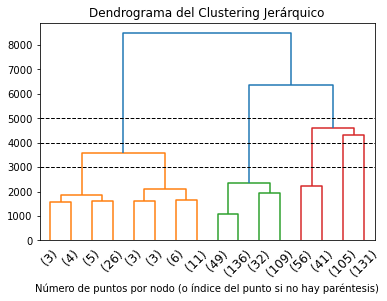

In [10]:
# Fijamos `distances_threshold=0` para que se calcule todo el árbol
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward' )   

# Lo entrenamos con nuestros datos
model = model.fit(X)

plt.title("Dendrograma del Clustering Jerárquico")
# fijando p=3 mostramos los tres primeros níveles del dendrograma.
plot_dendrogram(model, truncate_mode="level", p=3)  
plt.axhline(y=5000,linestyle="--",color="k",linewidth=1)
plt.axhline(y=4000,linestyle="--",color="k",linewidth=1)
plt.axhline(y=3000,linestyle="--",color="k",linewidth=1)
plt.xlabel("Número de puntos por nodo (o índice del punto si no hay paréntesis)")
plt.xticks(rotation = 45)
plt.show()

Como hemos dicho antes, en el eje Y está representada la distancia entre clusters. A nosotros nos va a interesar que está distancia sea suficientemente grande ya que eso indicará que la partición hecha es estable. En cambio, cuando veamos un salto pequeño en el eje Y, eso indicará que la partición no es tan estable. 

Así, observando el dendrograma podríamos tomar varias decisiones: 

* Por un lado, cortar por la línea horizontal de 5000. Esto nos daría tres clusters, dos de ellos balanceados y uno con menor número de muestras. Estos clusters están lo suficientemente alejados para afirmar que no tienen patrones en común con el resto. 

* Por otro lado, podríamos decidir cortar por la línea horizontal de 4000. Esto supondría que ahora tendríamos cinco clusters con menos muestras cada uno.

* Por último, podríamos cortar por la línea horizontal de 3000, lo que nos daría una división en seis clusters.

Cualquiera de las tres decisiones puede ser buena, sin embargo hay factores que nos hace decidirnos por una. Si nos fijamos en el final del dendrograma, tenemos que la unión entre los grupos (105) y (131) se hace muy arriba. Esto quiere decir que la distancia entre ambos grupos es grande y, por tanto podría tener sentido que fueran lo suficientemente diferentes. Así, podríamos descartar el agrupamiento en tres clusters. 

Ya solo nos quedarían el agrupamiento en cinco y en seis clusters. El factor decisivo en este caso es el número de elementos en cada grupo. Si nos quedamos con el de seis clusters, entonces tendríamos dos clusters (los de la izquierda) con muy pocos elementos en comparación con el resto de grupos. 

Por tanto, viendo el dendrograma nosotros diríamos que a priori puede haber cinco grupos distintos en nuestros datos. 


Para comparar la información obtenida con las etiquetas reales del problema, lo que haremos será volver a hacer un clustering jerárquico pero ahora fijando el número de clusters a seis. Echaremos un vistazo a las etiquetas predichas y usaremos las métricas definidas para obtener algunos resultados cuantitativos. 

In [11]:
model = AgglomerativeClustering(n_clusters=6, linkage='ward' )   

model = model.fit(X)
y_Aggl = model.labels_

print('Indice de Rand Ajustado: %.2f '%adjusted_rand_score(y,y_Aggl))
print('Medida V: %.2f '% v_measure_score(y,y_Aggl))
print('Indice de Silhouette: %.2f '%silhouette_score(X, y_Aggl))

Indice de Rand Ajustado: 0.15 
Medida V: 0.26 
Indice de Silhouette: 0.13 


Observamos que los resultados obtenidos no son muy buenos. El índice de Rand ajustado junto con la medida V nos dicen que no hay mucho parecido entre las etiquetas predichas y las reales. 

El índice de Silhouette confirma lo mismo que las otras medidas y además como es un valor cercano a cero, nos indica que puede existir solapamiento entre los diferentes clusters. 

El solapamiento entre clusters hace más complicado este primer análisis sin las etiquetas.

### Clustering basado en densidad. MeanShift

En este tipo de métodos nos fijamos en la acumulación de puntos. Lo que buscamos son zonas densas dónde haya muchas muestras juntas y, dentro de las densas, nos interesarán las más densas posibles. 

Así, estos métodos consisten en elegir una región del espacio, calcular la media (o la moda) de los puntos que caigan dentro y moverme hacia ella. Con esto conseguimos movernos hacia una región más densa. Si repetimos esto de forma iterativa, acabaremos alcanzando la zona más densa de mi nube de puntos. 

Para seleccionar la región del espacio, se usan lo que se conoce como ventanas. Al mirar por la ventana lo que estamos haciendo es calcular la media ponderada de los puntos de esa región.

Precisamente en esto consiste el algoritmo **Meanshift**. Este método nos asegura la convergencia hacia un punto estacionario. Los puntos del espacio que converjan al mismo centro, pertenecerán al mismo cluster. 

Cabe destacar, que el algoritmo **Meanshift** supone que hay una gradación de la densidad de nuestros puntos. Si esto no ocurre, el algoritmo no funcionará correctamente. 

Uno de los hiperparámetros del algoritmo **Meanshift** es la anchura de la ventana. Si cogemos una ventana muy grande, puede que estemos teniendo en cuenta puntos muy alejados a la hora de calcular la media y entonces ésta nos salga desvíada hacia una región poco densa. Si cogemos una anchura de ventana muy pequeña, el tiempo de computación puede aumentar considerablemente y además obtener demasiados clusters. 

Existe una función que nos permite estimar este parámetro y será la que utilicemos. 

In [12]:
# Estimación de la anchura de ventana

bandwidth = estimate_bandwidth(X, quantile=0.3,random_state=0)

print("Estimated bandwidth=%.2f"%bandwidth)

Estimated bandwidth=687.78


Procedemos a utilizar el algoritmo **MeanShift**.

In [13]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, 
               cluster_all=True).fit(X)

y_ms = ms.labels_
cluster_centers = ms.cluster_centers_
y_ms_unique = np.unique(y_ms)
n_clusters_ = len(y_ms_unique ) - (1 if -1 in y_ms else 0)

print('Bandwidth: ' , bandwidth)
print("number of estimated clusters : %d" % n_clusters_)
print('Labels: ' , set(y_ms))

Bandwidth:  687.7779513888889
number of estimated clusters : 3
Labels:  {0, 1, 2}


Observamos que con la anchura de ventana estimada y nuestros datos, el resultado del MeanShift es que hay tres grupos solamente en nuestros datos. Sin embargo, nosotros sabemos que en realidad hay seis clusters correspondientes a cada una de las clases del problema, por lo que el resultado obtenido no es muy bueno. 

La respuesta que nos da el algoritmo MeanShift se puede deber a que existe solapamiento entre los clusters. Por tanto, no es capaz de distinguir seis regiones densas distintas, sino que esas zonas se entremezclan dando lugar a solo tres regiones. 

Para poder comparar de forma cuantitativa con las etiquetas reales del problema, vamos a jugar con el ancho de ventana para que el resultado del clustering sea de seis grupos. Por ejemplo, fijando `bandwidth=650` obtenemos dicho resultado.

In [14]:
bandwidth=650
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, 
               cluster_all=True).fit(X)

y_ms2 = ms.labels_
cluster_centers2 = ms.cluster_centers_
y_ms_unique2 = np.unique(y_ms2)
n_clusters_2 = len(y_ms_unique2 ) - (1 if -1 in y_ms2 else 0)

print('Bandwidth: ' , bandwidth)
print("number of estimated clusters : %d" % n_clusters_2)
print('Labels: ' , set(y_ms2))

Bandwidth:  650
number of estimated clusters : 6
Labels:  {0, 1, 2, 3, 4, 5}


Para comparar con las etiquetas reales, usamos las mismas métricas que hemos presentado al inicio del apartado. 

In [15]:
print('Indice de Rand Ajustado: %.2f '%adjusted_rand_score(y,y_ms2))
print('Medida V: %.2f '% v_measure_score(y,y_ms2))
print('Indice de Silhouette: %.2f '%silhouette_score(X, y_ms2))

Indice de Rand Ajustado: 0.01 
Medida V: 0.11 
Indice de Silhouette: 0.31 


El índice de Rand ajustado y la medida V nos indican que hay poca similitud en general y en cuanto a homogeneidad y completitud. 

El índice de Silhouette sin embargo, es algo mayor pero tampoco es muy bueno. Se aleja un poco del cero, lo que quiere decir que no existe tanto solapamiento entre los clusters calculados.  

Viendo las tres métricas calculadas, concluimos que tampoco es un clustering que sea compatible con las etiquetas reales.

### Conclusiones

Viendo los resultados de los dos algoritmos de clustering llevados a cabo, podemos concluir que éstos no son compatibles con las etiquetas reales en las que existen seis grupos de datos. Esto se puede deber a diversos factores: 

* Existencia de ruido en las muestras que dificulta la labor del agrupamiento. 

* Muestras que contengan atributos erróneos. 

* Solapamiento entre clusters. Probablemente producido por la cantidad de características de cada muestra que tenemos.  

* Falta de estructura en los clusteres debido a la alta dimensionalidad de los datos.  

Estos últimos puntos lo abordaremos más adelante en el trabajo. Por eso, cuando hagamos una selección de las características más importantes, reduciendo así la dimensión, volveremos a probar los algoritmos de clustering para ver si mejoran los resultados. 

## ALGORITMOS SUPERVISADOS

### Primera parte: Estudio de los métodos para la reducción de datos.  

En el enunciado se pide que reduzcamos la cantidad de datos disponibles mediante alguna técnica de aprendizaje no supervisado, para así obtener un 50% compuesto de respresentantes de cada clase.   
Así pues, en este apartado vamos a estudiar como se puede realizar la reducción del conjunto de entrenamiento al 50% de la mejor manera posible.  
Las opciones que se barajan son:  
* Uso de KMeans para localizar representantes de cada clase mediante cercania a los centroides.  
* Uso de KMedoids para lo mismo, pero ahora los representantes son directamente elementos del conjunto.  
* Uso de gausianas, buscando los puntos más cercanos a los centros de las gausianas ajustadas.  

También contamos con dos estrategias:  
1. Podemos seleccionar tantos centroides (o medioides o gaussianas) como representantes queremos obtener (el 50% del total).  
2. Podemos intenter ajustar los datos a un número óptimo de clusters, y seleccionar los puntos con menos distancia a estas posiciones centrales.  

Primero investigaremos cual de estas dos estrategias parece tener mejores resultados, usando unos datos simulados. 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


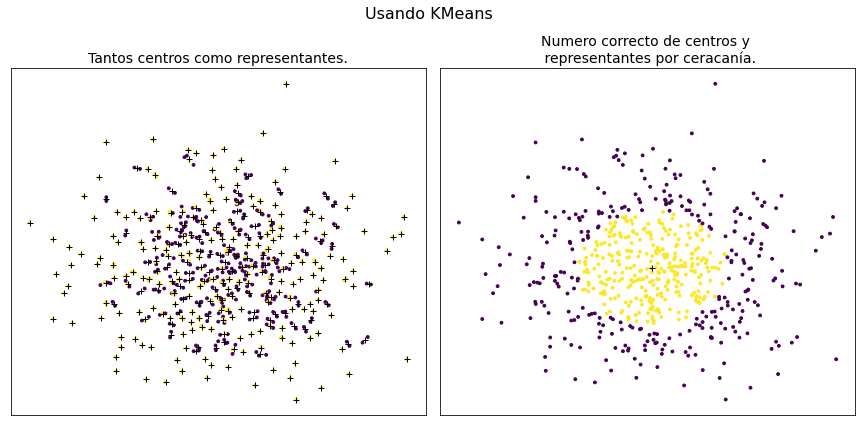

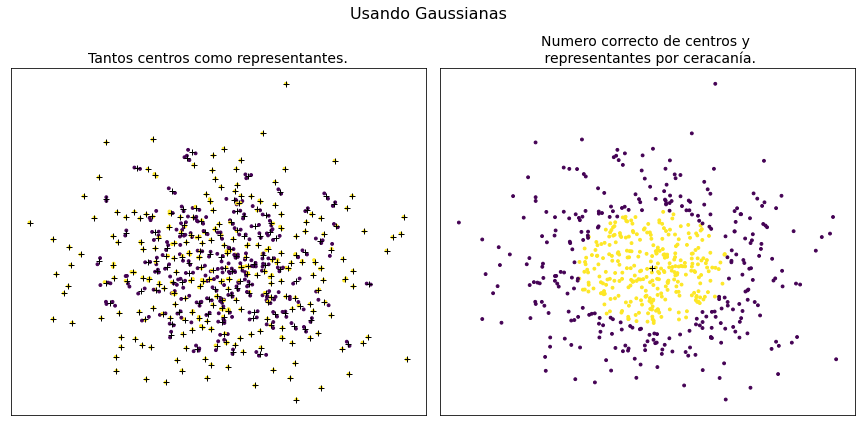

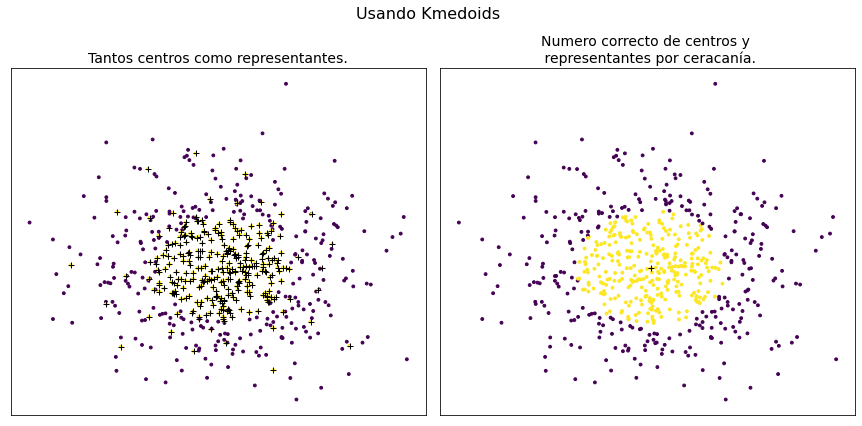

In [16]:
#vamos a hacer un ejemplo sencillo con ambas estrategias 
#para los tres métodos (KMeans, Kmedoids, Gaussians)

#primero creamos los datos 
n=600
data=make_blobs(n,centers=1,cluster_std=1.5)


#primero para KMeans
fig=plt.figure(figsize=(24,6))
n_clusters=[300,1]
titles=["Tantos centros como representantes.","Numero correcto de centros y \n representantes por ceracanía."]

for j,i in enumerate(n_clusters):
    plt.subplot(1,4,j+1)
    modelmeans=KMeans(n_clusters=i)
    modelmeans.fit(data[0])

    points_represent=get_closer_points(modelmeans.cluster_centers_,data[0],n=300)
    plt.scatter(data[0][:,0],data[0][:,1],c=points_represent,s=8)
    plt.plot(modelmeans.cluster_centers_[:,0],modelmeans.cluster_centers_[:,1],"+k")
    plt.title(titles[j],fontsize=14)
    plt.xticks([]);
    plt.yticks([]);
plt.suptitle("Usando KMeans",fontsize=16,x=0.25)
plt.tight_layout()

#segundo para las Gaussianas
fig=plt.figure(figsize=(24,6))
n_clusters=[300,1]
titles=["Tantos centros como representantes.","Numero correcto de centros y \n representantes por ceracanía."]

for j,i in enumerate(n_clusters):
    plt.subplot(1,4,j+1)
    modelgaus=GaussianMixture(n_components=i)
    modelgaus.fit(data[0])
    points_represent=get_closer_points(modelgaus.means_,data[0],n=300)
    plt.scatter(data[0][:,0],data[0][:,1],c=points_represent,s=8)
    plt.plot(modelgaus.means_[:,0],modelgaus.means_[:,1],"+k")
    plt.title(titles[j],fontsize=14)
    plt.xticks([]);
    plt.yticks([]);
plt.suptitle("Usando Gaussianas",fontsize=16,x=0.25)
plt.tight_layout()

#Tercero para Kmedoids
fig=plt.figure(figsize=(24,6))
n_clusters=[300,1]
titles=["Tantos centros como representantes.","Numero correcto de centros y \n representantes por ceracanía."]
#primer subplot
plt.subplot(1,4,1)
modelmedoids=KMedoids(n_clusters=300)
modelmedoids.fit(data[0])
color_aux=np.full(data[0].shape[0],False,dtype=bool)
color_aux[modelmedoids.medoid_indices_]=True
plt.scatter(data[0][:,0],data[0][:,1],c=color_aux,s=8)
plt.plot(modelmedoids.cluster_centers_[:,0],modelmedoids.cluster_centers_[:,1],"+k")
plt.title(titles[0],fontsize=14)
plt.xticks([]);
plt.yticks([]);
#segundo subplot
plt.subplot(1,4,2)
modelmedoids=KMedoids(n_clusters=1)
modelmedoids.fit(data[0])
points_represent=get_closer_points(modelmedoids.cluster_centers_,data[0],n=300)
plt.scatter(data[0][:,0],data[0][:,1],c=points_represent,s=8)
plt.plot(modelmedoids.cluster_centers_[:,0],modelmedoids.cluster_centers_[:,1],"+k")
plt.title(titles[1],fontsize=14)
plt.xticks([]);
plt.yticks([]);

plt.suptitle("Usando Kmedoids",fontsize=16,x=0.25)
plt.tight_layout()

Las gráficas anteriores ejemplifican perfectamente el problema de intentar ajustar tantas gaussianas o centroides como representantes se desea obtener. El problema es que dichos centros se separarán entre si para no solapar, y esto hace que no obtengamos representantes sino que obtengamos un muestreo de los datos que solo atiende a pequeñas agrupaciones de puntos o quizá ni eso en muchos casos. Los representantes que obtenemos cuando escogemos de forma acertada el número de clusters, son muchos más adecuados, a excepción de los medoides cuyo resultado final es bastantes similar.  

Sin embargo nuestro problema cuenta con una dimensionalidad altísima y no podemos realizar un estudio visual como el anterior, para determinar el número correcto de clusters. Además los clusters debido a la llamada _"maldición de la dimensionalidad"_ estarán muy repartidos y posiblemente no tengan una forma muy compacta.   
A este respecto valoramos dos opciones:  
1. Hacer pruebas sobre el conjunto completo de datos y probar distintos valores para el número de clusteres, y medir la eficiencia con los estadísticos y coeficientes adecuados.  
2. Para cada clase realizar clustering para los valores de esa etiqueta, encontrar el centro (centroide, medoide o media según el algoritmo) y seleccionar la mitad de las muestras más cercanas a dicho centro para cada clase individualmente.  

Nos parece que la segunda opción es la que puede dar mejores resultados (usando KMeans), de modo que procedemos con ella.   



In [17]:
#elección de representantes, la eleccion la haremos mediante kmeans
clases=np.unique(y).shape[0]

X_reduc=[]
y_reduc=[]

for i in range(clases):
    #la eleccion de los puntos mas cercanos al centroide la hacemos para cada clase
    len_aux=len(y[y==i])
    model=KMeans(n_clusters=1, random_state=0)
    model.fit(X[y==i])  
    points_represent=get_closer_points(model.cluster_centers_,X[y==i],n=len_aux//2)
    X_reduc.append(X[y==i][points_represent])
    y_reduc.extend(np.ones(sum(points_represent))*i)
X_reduc=np.array(X_reduc)
y_reduc=np.array(y_reduc)
X_reduc2=X_reduc.reshape(-1,464)


#separamos los datos en conjuntos para entrenamiento y para test
#lo hacemos tanto para el conjunto completo como  para el reducido por representantes
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
X_reduc_train,X_reduc_test,y_reduc_train,y_reduc_test=train_test_split(X_reduc2,y_reduc,
                                                                       test_size=0.2,random_state=0)
  

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\cluster\_kmeans.py:8

### Segunda parte: Construccion de los algoritmos.  
Vamos a intentar resolver el problema mediante algoritmos de aprendizaje supervisado.  
A primera vista, el algoritmo que parece más indicado para la tarea es el de **máquinas de vector soporte** para clasificación, pues contamos con una dimensionalidad muy alta y (tras la reducción al 50%) la cantidad de ejemplo para entrenar el modelo no es muy grande.  
Los modelos que vamos a probar son:  
- Arboles  
- MLP  
- SVM  
- Vecinos próximos.  
 

**Nota:** Vamos a hacer uso de validación cruzada para la selección de hiperparámetros, más concretamente del algoritmo k-folds con $k=5$.

#### Arboles 

Para el caso de los árboles además de hacer tuning de los hiperparámetros, también tenemos la opción de la **post-poda** lo cual nos podría resultar en un arbol simplificado que de mejores resultados.  
Para proceder primero escogeremos los hiperparámetros que funcionen mejor con **pre-poda** y como paso final, probaremos si la **post-poda** mejora los resultados.

In [18]:
%%time
#gridsearch
tree_params={"criterion":["gini","entropy"],"max_depth":np.arange(2,50,2)}

#lo evaluamos 

model_tree=DecisionTreeClassifier(random_state=0)

tree_best=GridSearchCV(model_tree,tree_params)
tree_best.fit(X_reduc_train,y_reduc_train);
print("La mejor precision (",tree_best.best_score_,") ha sido obtenida con los parametros: "
      ,tree_best.best_params_)

La mejor precision ( 0.46890502117362365 ) ha sido obtenida con los parametros:  {'criterion': 'gini', 'max_depth': 4}
Wall time: 28.7 s


Podemos visualizar el aprendizaje de los arboles ploteando su precisión en la predicción en función de la profundidad del arbol.  
Y también vamos a estudiar como mejora (o empeora) el modelo conforme hacemos la **post-poda**.  

Max acc on test data pre-prunning: 0.611 
Max acc on test data post-prunning: 0.625


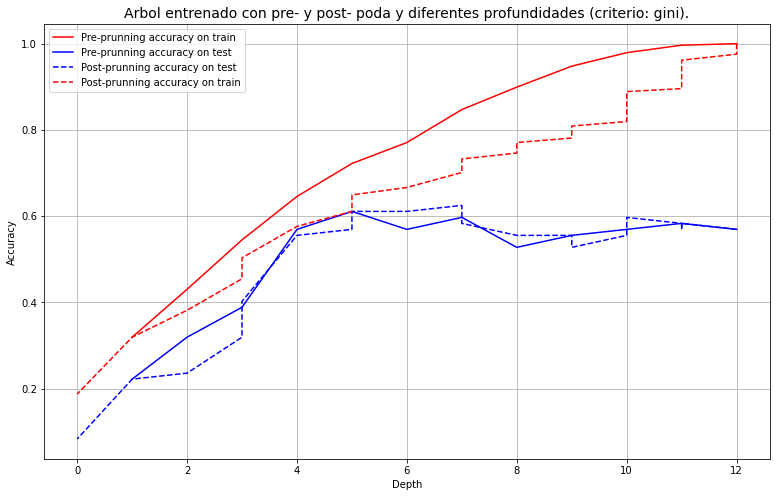

In [19]:
plt.figure(figsize=(13,8))

#primero los entrenamos en pre-poda

acc_train_list=[]
acc_test_list=[]
depths=list(range(1,13))
for i in depths:
    model=DecisionTreeClassifier(criterion="gini",max_depth=i,random_state=0)
    model.fit(X_reduc_train,y_reduc_train)
    y_pred_1=model.predict(X_reduc_train)
    acc_train_list.append(accuracy_score(y_reduc_train,y_pred_1))
    y_pred_2=model.predict(X_reduc_test)
    acc_test_list.append(accuracy_score(y_reduc_test,y_pred_2))

plt.title("Arbol entrenado con pre- y post- poda y diferentes profundidades (criterio: gini).",fontsize=14)
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.plot(depths,acc_train_list,"r",label="Pre-prunning accuracy on train")
plt.plot(depths,acc_test_list,"b",label="Pre-prunning accuracy on test")

#ahora hacemos la post-poda
aux=model.cost_complexity_pruning_path(X_reduc_train,y_reduc_train)
ccp,imps=aux.ccp_alphas, aux.impurities
acc_train_list_pruned=[]
acc_test_list_pruned=[]
node_counts=[]
models=[]
for i in ccp:
    model=DecisionTreeClassifier(ccp_alpha=i,random_state=0)
    model.fit(X_reduc_train,y_reduc_train)
    models.append(model)
    y_pred_1=model.predict(X_reduc_train)
    node_counts.append(model.get_depth())
    acc_train_list_pruned.append(accuracy_score(y_reduc_train,y_pred_1))
    y_pred_2=model.predict(X_reduc_test)
    acc_test_list_pruned.append(accuracy_score(y_reduc_test,y_pred_2))

plt.plot(node_counts,acc_test_list_pruned,"b--",label="Post-prunning accuracy on test")
plt.plot(node_counts,acc_train_list_pruned,"r--",label="Post-prunning accuracy on train")
plt.legend()
plt.grid()

print("Max acc on test data pre-prunning: %.3f " % max(acc_test_list))
print("Max acc on test data post-prunning: %.3f" % max(acc_test_list_pruned))




En la gráfica anterior vemos como el mejor resultado (en el conjunto de test) se da con una profundidad de 7, y tras aplicar la **post-poda**. Por tanto, vemos que aplicar post-poda resulta en una mejora del modelo en este caso.

In [20]:
indice = np.where(acc_test_list_pruned==max(acc_test_list_pruned))
indice[0]    # Mejores aciertos en los índices 46 y 47

array([46, 47], dtype=int64)

In [21]:
tree_best_prunned = models[46]
tree_best_prunned

DecisionTreeClassifier(ccp_alpha=0.01785078347578348, random_state=0)

#### MLP 
Si usamos un perceptron multicapa, este debería ser entrenado con todos los datos disponibles, y no vemos motivo alguno a limitarnos usando solo unos cuantos representantes de cada clase. Esto es dicutido más adelante, donde ambos cojuntos son usados (reducido y sin reducir) para el entrenamiento. 

In [22]:
%%time

#sin normalizar los datos de entrada, pero con el set reducido
mlp_params={"hidden_layer_sizes":[(100,20),(100),(20,20),(10),(20,20,20)],"activation":["logistic","tanh", "relu"],
            "solver":["sgd","adam"]}


model_mlp=MLPClassifier(max_iter=500,verbose=False,early_stopping=True,random_state=0)
mlp_best=GridSearchCV(model_mlp,mlp_params)
mlp_best.fit(X_reduc_train,y_reduc_train)
print("La mejor precision (",mlp_best.best_score_,") ha sido obtenida con los parametros: "
      ,mlp_best.best_params_)


La mejor precision ( 0.46872353297035685 ) ha sido obtenida con los parametros:  {'activation': 'relu', 'hidden_layer_sizes': 100, 'solver': 'sgd'}
Wall time: 9.84 s


In [23]:
%%time
#sin normalizar los datos de entrada y usando el set de datos sin reducir
mlp_params={"hidden_layer_sizes":[(100,20),(100),(20,20),(10),(20,20,20)],"activation":["logistic","tanh", "relu"],
            "solver":["sgd","adam"]}


model_mlp=MLPClassifier(max_iter=500,verbose=False,early_stopping=True,random_state=0)
mlp_best=GridSearchCV(model_mlp,mlp_params)
mlp_best.fit(X_train,y_train)
print("La mejor precision (",mlp_best.best_score_,") ha sido obtenida con los parametros: "
      ,mlp_best.best_params_)

La mejor precision ( 0.5641979010494753 ) ha sido obtenida con los parametros:  {'activation': 'relu', 'hidden_layer_sizes': 100, 'solver': 'sgd'}
Wall time: 22.8 s


Podemos ver que efectivamente, el modelo entrenado con mayor cantidad de datos a resultado tener una precisión más alta. Limitar el conjunto de entrenamiento a solo unos pocos representantes no ha sido de ayuda en este caso, en el caso de las redes es mejor tener cuantos más datos mejor.

#### SVM  
Tal como mencionábamos al comienzo de este apartado de aprendizaje supervisado, este algoritmo a primera vista parece ser el más adecuado para el problema que se nos plantea (por la alta dimensionalidad y la relativa escasez de datos). 

In [24]:
%%time
#gridsearch
gamma_scale=1/(X_reduc_train.shape[-1]*np.var(X_reduc_train.flatten()))
svm_params={"C":np.linspace(1,1.4,30),"gamma":np.linspace(gamma_scale*0.5,gamma_scale*2,30)}


model_svm=SVC(random_state=0)
svm_best=GridSearchCV(model_svm,svm_params)
svm_best.fit(X_reduc_train,y_reduc_train)
print("La mejor precision (",svm_best.best_score_,") ha sido obtenida con los parametros: "
      ,svm_best.best_params_)
print("Los extremos para el rango de gamma son: ",gamma_scale*0.5,gamma_scale*2)

La mejor precision ( 0.6666666666666666 ) ha sido obtenida con los parametros:  {'C': 1.2206896551724138, 'gamma': 7.947433522470327e-06}
Los extremos para el rango de gamma son:  2.4260586542277838e-06 9.704234616911135e-06
Wall time: 2min 4s


**Nota:** Todos los hiperparametros probados no son los que se muestran aquí, ha habido pruebas previas que se han descartado por falta de eficiencia, como por ejemplo probar un kernel polinómico, una vez quedó claro que el "rbf" daba mejores resultados, el polinómico ni lo teniamos en cuenta a la hora de ajustar el resto de hiperparámetros.

#### Vecinos próximos  
Este algoritmo si bien es de clustering, lo hemos incluido en este apartado pues requiere de un conjunto de entrenamiento para la clasificación del resto de elementos según los k vecinos más próximos a cada punto del que se desea predecir la clase.   

In [25]:
%%time
#normalizando los datos de entrada
nearestn_params={"n_neighbors":[1,2,3],"weights":["uniform", "distance"],
                 "algorithm":["ball_tree", "kd_tree", "brute"]} #metric:??


model_nearestn=KNeighborsClassifier()
nearestn_best=GridSearchCV(model_nearestn,nearestn_params)
nearestn_best.fit(X_reduc_train,y_reduc_train)
print("La mejor precision (",nearestn_best.best_score_,") ha sido obtenida con los parametros: "
      ,nearestn_best.best_params_)

La mejor precision ( 0.48608590441621297 ) ha sido obtenida con los parametros:  {'algorithm': 'ball_tree', 'n_neighbors': 2, 'weights': 'uniform'}
Wall time: 1.29 s


**Conclusiones:**  
En lo relativo a algortimos supervisados, hemos observado que los mejores resultados vienen dados por las **máquinas de vector soporte** y los **MLP** entrenados con un conjunto no reducido de datos. 

## IMPORTANCIA DE CARACTERÍSTICAS

En este apartado, vamos a utilizar clasificadores del tipo árboles de decisión para intentar predecir las etiquetas de nuestro conjunto de datos. Usaremos este tipo de clasificadores porque entre sus atributos se encuentra la importancia de características. 

La importancia de las características es una información muy útil porque nos permite saber qué atributos no son relevantes para nuestro modelo. 

Entonces haremos lo siguiente: 

* Primero usaremos el árbol de decisión con los mejores parámetros calculados en el apartado anterior. 

* Depués veremos cuáles son las características más importantes con el atributo `feature_importances_`. 

* Finalmente, eliminaremos todas aquellas características que tengan una importancia de cero. Nos quedaremos con el resto y volveremos a entrenar el árbol de decisión para ver si mejoran (o no empeoran) los resultados. 

Cabe destacar que, en el caso de los árboles de decisión, la importancia de una caracaterística se calcula como la reducción total (normalizada) del criterio de división (normalemente la impureza de Gini) al dividir por dicha característica.

**Nota:** 

Si el clasificador que estamos usando no tiene directamente un atributo que nos de la importancia de las características, podemos usar la función `permutation_importance`. Esta implementación lo que hace es barajar una de las características y volver a entrenar el modelo con dicha característica permutada. Después comprueba si el rendimiento cambia mucho o no. Si cambia mucho, entonces diremos que esa variable es importante, y si cambia poco diremos que no lo es. Esto lo repite para cada una de las características y así nos ofrece un valor cuantitativo de la importancia de cada característica.

También lo probaremos en este apartado usando máquinas de vector soporte.

### Árboles de decisión

Así, vamos a calcular un "ranking" de características para nuestro árbol de decisión. 

Para ello, cogemos el árbol de decisión calculado en el apartado anterior y usamos el atributo de `feature_importances_` para ver la importancia de las características. Nos quedaremos con aquellas cuya importancia sea no nula.

In [26]:
# El árbol que mejores resultados nos daba con nuestros datos.
clf_tree = tree_best_prunned
clf_tree.fit(X_reduc_train,y_reduc_train)

DecisionTreeClassifier(ccp_alpha=0.01785078347578348, random_state=0)

Calculamos una estimación del acierto en entrenamiento y en test mediante cross-validation. 

In [27]:
print('OA train %0.2f' % np.mean(cross_val_score(clf_tree, X_reduc_train,y_reduc_train, scoring='accuracy', cv=5)))
print('OA test %0.2f' % np.mean(cross_val_score(clf_tree, X_reduc_test,y_reduc_test, scoring='accuracy', cv=5)))

OA train 0.42
OA test 0.36


Cálculo de las importancias.

In [28]:
importancias=clf_tree.feature_importances_
# print(importancias)           descomentar para ver el resultado exacto de la importancia de cada característica.      

Selección de características.

In [29]:
indices=np.where(importancias!=0)
X_reduc2_2=X_reduc2[:,indices]
print(X_reduc2_2.shape)
X_reduc2_2= X_reduc2_2.reshape((360,len(indices[0])))
print(X_reduc2_2.shape)

(360, 1, 9)
(360, 9)


In [30]:
indices  # Características seleccionadas

(array([  0,   1,   2,   4,   5,  10,  33, 116, 221], dtype=int64),)

Tras calcular la importancia de las características, observamos que tan solo hay ocho cuya importancia sea no nula. Por tanto, nos quedamos solo con esas características y volvemos a evaluar el rendimiento del clasificador.

In [31]:
Xtr, Xts, ytr, yts = train_test_split(X_reduc2_2, y_reduc, test_size=0.2, shuffle=True, random_state=0)

# El árbol que mejores resultados nos daba con nuestros datos.
clf_tree = tree_best_prunned
clf_tree.fit(Xtr,ytr);

In [32]:
print('OA train %0.2f' % np.mean(cross_val_score(clf_tree, Xtr, ytr, scoring='accuracy', cv=3)))
print('OA test %0.2f' % np.mean(cross_val_score(clf_tree, Xts, yts, scoring='accuracy', cv=3)))

OA train 0.56
OA test 0.57


Observamos que tras eliminar la gran mayoría de las características, los aciertos en test y en entrenamiento han mejorado. Esto se debe a que tan solo había unas pocas características relevantes para nuestro árbol de clasificación que son las que estaban tomando realmente las decisiones, y el resto de atributos no participaba.

### SVM

Vamos a hacer también una selección de características para el caso en el que estamos clasificando con una máquina de vector soporte. Lo separamos del caso anterior porque las características que son importantes para un método puede que no lo sean para otro. 

De hecho, el clasificador de las máquinas de vector soporte (SVC) no tiene un atributo como tal que nos dé la importancia de las características, sino que tenemos que usar una función auxiliar (`permutation_importance`). 

Así, cogemos de nuevo el SVC con los parámetros óptimos calculado en el apartado anterior y trabajamos sobre él.

In [33]:
clf_svc = svm_best.best_estimator_
clf_svc.fit(X_reduc_train,y_reduc_train)


print('OA train %0.2f' % np.mean(cross_val_score(clf_svc,X_reduc_train,y_reduc_train, scoring='accuracy', cv=5)))
print('OA test %0.2f' % np.mean(cross_val_score(clf_svc, X_reduc_test,y_reduc_test, scoring='accuracy', cv=5)))

OA train 0.67
OA test 0.47


Los resultados no son malos. Calculamos la importancia de las características usando  `permutation_importance` y nos quedamos solo con las relevantes. Volvemos a evaluar el modelo para ver si mejora (o no empeora).

In [34]:
resultado = permutation_importance(clf_svc, X_reduc2, y_reduc,scoring='accuracy', n_repeats=5, random_state=0)

In [35]:
importancias_svc = resultado.importances_mean
#importancias_svc  #descomentar para ver los valores exactos de importancia de cada característica.

Selección de características.

In [36]:
indices2=np.where(importancias_svc > abs(1e-2))
X_reduc3=X_reduc2[:,indices2]
print(X_reduc3.shape)
X_reduc3= X_reduc3.reshape((360,len(indices2[0])))
print(X_reduc3.shape)

(360, 1, 4)
(360, 4)


In [37]:
indices2  
# Las mismas características seleccionadas que con el atributo de los árboles + dos adicionales .

(array([0, 1, 2, 3], dtype=int64),)

Una vez hecha la selección de las características más importantes, volvemos a entrenar el modelo con dichas características. Una vez entrenado, calculamos la estimación de aciertos para ver si no empeora con respecto al modelo con todas las características.

In [38]:
Xtr, Xts, ytr, yts = train_test_split(X_reduc3, y_reduc, test_size=0.2, shuffle=True, random_state=0)

clf_svc = svm_best.best_estimator_
clf_svc.fit(Xtr,ytr)


print('OA train %0.2f' % np.mean(cross_val_score(clf_svc, Xtr, ytr, scoring='accuracy', cv=5)))
print('OA test %0.2f' % np.mean(cross_val_score(clf_svc, Xts, yts, scoring='accuracy', cv=5)))

OA train 0.52
OA test 0.58


Es sorprendente que al eliminar características, los resultados en test no sufren grandes cambios y el modelo se simplifica significativamente. Es cierto que en entrenamiento baja un poco el acierto, pero no es preocupante. Además, a nosotros nos interesa que en test vaya bien para que el modelo sea capaz de generalizar. 

El hecho de que el acierto en test no varie mucho al eliminar gran cantidad de las características, se debe a que el resto de características no contenían informacion relevante, y el modelo generaliza bien.

Cabe destacar también que los aciertos están bastante balanceados, por lo que no debemos preocuparnos por el sobreajuste.

### Clustering

Como comentamos en el apartado de clustering, una vez hecha la reducción de características puede ser interesante volver a realizar algún algoritmo de agrupamiento para ver si los resultados mejoran al haber menos dimensiones. 

Aquí simplemente repetimos lo hecho anteriormente pero sobre el conjunto que contiene solo las características importantes.

#### Clustering Jerárquico Aglomerativo

Volvemos a hacer clustering aglomerativo imponiendo que me calcule seis clusters. Además, calculamos los mismo índices que en el primer apartado para comparar con las etiquetas reales y ver si ha habido una mejora significativa.

In [39]:
model = AgglomerativeClustering(n_clusters=6, linkage='ward' )   

model = model.fit(X_reduc2_2)
y_Aggl2 = model.labels_

print('Indice de Rand Ajustado: %.2f '%adjusted_rand_score(y_reduc,y_Aggl2))
print('Medida V: %.2f '% v_measure_score(y_reduc,y_Aggl2))
print('Indice de Silhouette: %.2f '%silhouette_score(X_reduc2, y_Aggl2))

Indice de Rand Ajustado: 0.15 
Medida V: 0.30 
Indice de Silhouette: 0.16 


A la vista de los resultados, no parece que haya mejorado mucho el resultado del clustering. Por tanto, parece que la dimensionalidad en este caso no era tan importante. 

Que los resultados no hayan cambiado mucho puede deberse a que las características más importantes siguen estando solapadas entre sí, lo que dificulta mucho la labor de buscar patrones y establecer grupos.

#### MeanShift

Comprobamos si con el clustering basado en densidad conseguimos mejorar los resultados.

In [40]:
# Estimación de la anchura de ventana

bandwidth = estimate_bandwidth(X_reduc2_2, quantile=0.3,random_state=0)

print("Estimated bandwidth=%.2f"%bandwidth)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, 
               cluster_all=True).fit(X_reduc2_2)

y_ms = ms.labels_
cluster_centers = ms.cluster_centers_
y_ms_unique = np.unique(y_ms)
n_clusters_ = len(y_ms_unique ) - (1 if -1 in y_ms else 0)

print('Bandwidth: ' , bandwidth)
print("number of estimated clusters : %d" % n_clusters_)
print('Labels: ' , set(y_ms))

Estimated bandwidth=246.48
Bandwidth:  246.47617554697692
number of estimated clusters : 7
Labels:  {0, 1, 2, 3, 4, 5, 6}


En este caso, vemos como el agrupamiento propuesto con los parámetros estimados tampoco parece acertado en cuánto al número de grupos. Sin embargo, se acerca más a nuestras etiqueta, lo que es una mejora con respecto al resultado que obteníamos en el primer apartado, donde el algoritmo MeanShift nos daba una predicción de tres grupos. 

Calculemos algunos de los índices para ver si acertamos asignando las etiquetas a los puntos. Para ello, hacemos un MeanShift con el ancho de banda adecuado para que nos salga un agrupamiento en seis clusters.  


In [48]:
bandwidth = 250
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, 
               cluster_all=True).fit(X_reduc2_2)

y_ms = ms.labels_
cluster_centers = ms.cluster_centers_
y_ms_unique = np.unique(y_ms)
n_clusters_ = len(y_ms_unique ) - (1 if -1 in y_ms else 0)

print('Bandwidth: ' , bandwidth)
print("number of estimated clusters : %d" % n_clusters_)
print('Labels: ' , set(y_ms))

Bandwidth:  250
number of estimated clusters : 6
Labels:  {0, 1, 2, 3, 4, 5}


In [49]:
print('Indice de Rand Ajustado: %.2f '%adjusted_rand_score(y_reduc,y_ms))
print('Medida V: %.2f '% v_measure_score(y_reduc,y_ms))
print('Indice de Silhouette: %.2f '%silhouette_score(X_reduc2, y_ms))

Indice de Rand Ajustado: 0.10 
Medida V: 0.29 
Indice de Silhouette: 0.28 


Además, tanto el índice de Rand como la medida V han sufrido un incremento en comparación al clustering que hacíamos con todas las características. No son resultados buenos tampoco, pero mejores que los que ya teníamos. 

El índice de Silhouette se mantiene más o menos igual. 


Por tanto, en el caso del clustering basado en densidad, hemos comprobado que una reducción de la dimensionalidad sí que mejora los resultados. Sobre todo en cuánto a la organización interna de los datos, ya que es capaz de detectar que existen seis grupos distintos entre nuestras muestras, cosa que es compatible con nuestras etiquetas.


### Algoritmos de clasificación que hacen uso de Ensembles  
En este apartado se probarán los algoritmos que tienen como piezas primarias _"weak learners"_, pero es el conjunto lo que permite que se contruya un predictor completo y funcional.  
Los modelos que se probarán son:  
- Random Forests. 
- Bagging (con árboles o como _weak learners_).   

Para entrenar ambos modelos usaremos no solo usaremos el conjunto reducido de datos (50% representantes de cada clase), sino que solo usaremos las características más relevantes.

Como se indica en el enunciado de la tarea, para el entrenamiento de los modelos que hacen uso de ensembles, usaremos solo los cojuntos reducidos tanto en características como en número datos.

In [43]:
Xtr, Xts, ytr, yts = train_test_split(X_reduc2_2, y_reduc, test_size=0.2, shuffle=True, random_state=0)

#### Random Forests

In [44]:
#gridsearch

forest_params={"n_estimators":np.rint(np.linspace(270,290,10)).astype(int),
               "max_depth":[2,3,4,5,6]}#"criterion":["gini","entropy"]

model_forest=RandomForestClassifier(random_state=0)
forest_best=GridSearchCV(model_forest,forest_params)
forest_best.fit(Xtr,ytr)
print("La mejor precision (",forest_best.best_score_,") ha sido obtenida con los parametros: "
      ,forest_best.best_params_)

La mejor precision ( 0.5901996370235935 ) ha sido obtenida con los parametros:  {'max_depth': 5, 'n_estimators': 283}


#### Bagging

In [45]:
bagging_params={"base_estimator":[SVC(random_state=0),DecisionTreeClassifier(random_state=0)],#MLPClassifier(40),
                "n_estimators":[4,12,16,26,40]}#:np.rint(np.geomspace(10,30,5)).astype(int)},
                #"max_features":[0.3,0.6,1.0]}
model_bagging=BaggingClassifier()
bagging_best=GridSearchCV(model_bagging,bagging_params)
bagging_best.fit(Xtr,ytr)
print("La mejor precision (",bagging_best.best_score_,") ha sido obtenida con los parametros: "
      ,bagging_best.best_params_)

La mejor precision ( 0.5970961887477315 ) ha sido obtenida con los parametros:  {'base_estimator': DecisionTreeClassifier(random_state=0), 'n_estimators': 16}


Recordemos que la diferencia entre bagging con árboles como predictores débiles y los ramdom forest, es que los random forest solo consideran un subconjunto aleatorio de características en cada _split_ del los árboles, mientras que bagging considera todas ellas en cada elección.

### Estadísticos y coeficientes para los mejores ajustes de cada modelo.   
Ahora vamos a sacar varios estadisticos de cada uno de los mejores modelos ajustados anteriormente. 

In [46]:
resultados=pd.DataFrame(columns=["Algoritmo","best_params","Accuracy_train","Accuracy_test",
                                 "Accuracy_kfold","Precision_test","Precision_kfold","Recall_test","Recall_kfold",
                                 "cohen-kappa_train","cohen-kappa_test",
                                 "f1_test","f1_kfold"])
names=["Tree","SVC","MLP","KNN","Forest","Bagging"]

for i,j in enumerate([tree_best,svm_best,mlp_best,nearestn_best,forest_best,bagging_best]):
    aux_series=train_and_get_stats(j.best_estimator_,X_reduc2,y_reduc,X_reduc_train,y_reduc_train,
                                   X_reduc_test,y_reduc_test,cv=5)
    aux_series=aux_series.append(pd.Series({"Algoritmo":names[i],"best_params":j.best_params_}))
    resultados=resultados.append(aux_series,ignore_index=True)
resultados

ValueError: X.shape[1] = 464 should be equal to 4, the number of features at training time